In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

<h2 align="center" style="color:blue">Data Loading</h2>

In [3]:
df = pd.read_excel("data/premiums_young_with_gr.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [4]:
df.shape

(20096, 14)

In [5]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


<h2 align="center" style="color:blue">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [6]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [7]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

### Handle Duplicates

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


#### Data Cleaning: number_of_dependants 

In [10]:
df[df['number_of_dependants']<0]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
150,23,Female,Southwest,Unmarried,-3,Underweight,No Smoking,Freelancer,10L - 25L,18,No Disease,Silver,9309,2
871,18,Male,Southwest,Unmarried,-3,Overweight,No Smoking,Freelancer,25L - 40L,28,No Disease,Silver,8095,0
906,19,Male,Northwest,Unmarried,-3,Underweight,No Smoking,Freelancer,25L - 40L,40,No Disease,Bronze,4641,1
2462,20,Male,Northeast,Unmarried,-3,Underweight,Regular,Freelancer,10L - 25L,20,Diabetes,Silver,9640,1
3059,20,Female,Southwest,Unmarried,-3,Underweight,No Smoking,Salaried,> 40L,77,No Disease,Silver,9299,2
3120,25,Male,Northwest,Unmarried,-1,Underweight,No Smoking,Salaried,10L - 25L,13,No Disease,Bronze,7234,3
3780,23,Female,Southeast,Unmarried,-3,Normal,Regular,Freelancer,25L - 40L,40,No Disease,Bronze,5003,0
5593,25,Male,Northwest,Unmarried,-1,Normal,No Smoking,Salaried,10L - 25L,20,No Disease,Bronze,6299,2
7585,22,Male,Northwest,Unmarried,-3,Normal,Occasional,Self-Employed,<10L,8,No Disease,Gold,13596,2
9765,18,Female,Southeast,Unmarried,-1,Underweight,No Smoking,Self-Employed,<10L,4,No Disease,Bronze,9366,5


In [11]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1])

We can see some negative values in number_of_dependants. We can replace them with positive numbers.

In [12]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [13]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

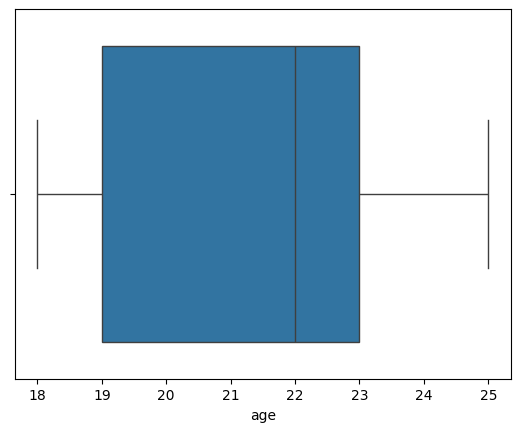

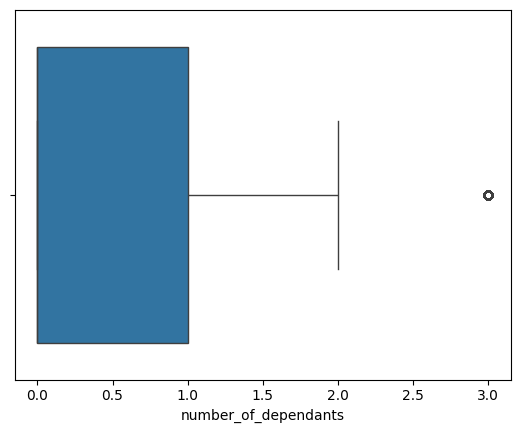

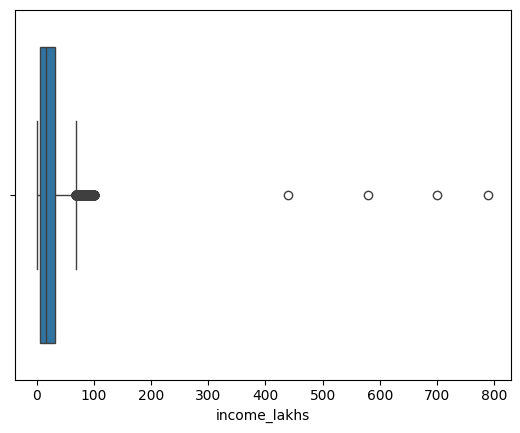

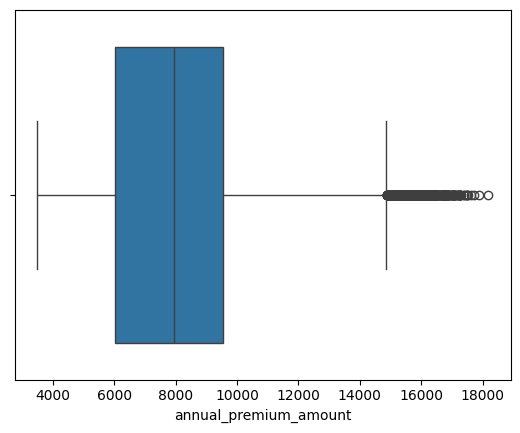

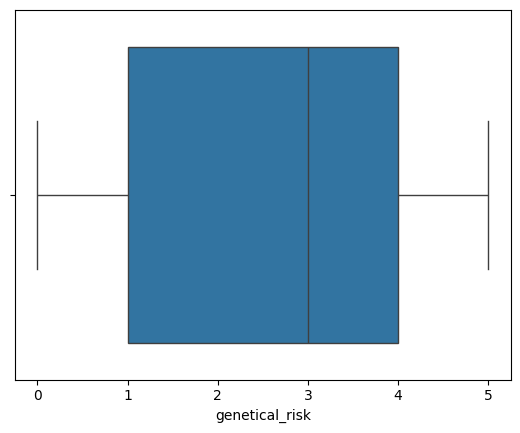

In [14]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

### Outlier Treatment: Age Column

In [15]:
df[df['age']>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


In [16]:
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [17]:
df1 = df[df['age']<=100]
df1['age'].describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

### Outlier Treatment: Income Column

In [18]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [19]:
df1[df1['income_lakhs']>upper]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
10,22,Female,Southwest,Unmarried,0,Normal,No Smoking,Salaried,> 40L,70,No Disease,Silver,11305,4
32,18,Male,Southwest,Unmarried,0,Normal,Regular,Self-Employed,> 40L,92,No Disease,Silver,8351,0
41,19,Male,Southeast,Unmarried,0,Normal,No Smoking,Salaried,> 40L,90,No Disease,Silver,9370,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20034,21,Male,Northeast,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,99,No Disease,Gold,15658,5
20042,23,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,96,No Disease,Gold,16416,5
20046,24,Male,Southwest,Unmarried,1,Normal,No Smoking,Self-Employed,> 40L,69,No Disease,Gold,15547,5
20082,18,Female,Southeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,89,No Disease,Silver,9783,2


In [20]:
df1[df1['income_lakhs']>upper].shape

(1295, 14)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence, we will use a simple quantile bound.

In [21]:
quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold

np.float64(100.0)

In [22]:
df1[df1['income_lakhs'] > quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
1677,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636,3
4311,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888,5
4661,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424,3
6251,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586,0


In [23]:
df1[df1['income_lakhs'] > quantile_threshold].shape

(4, 14)

In [24]:
df2 = df1[df1['income_lakhs'] <= quantile_threshold].copy()
df2.shape

(20086, 14)

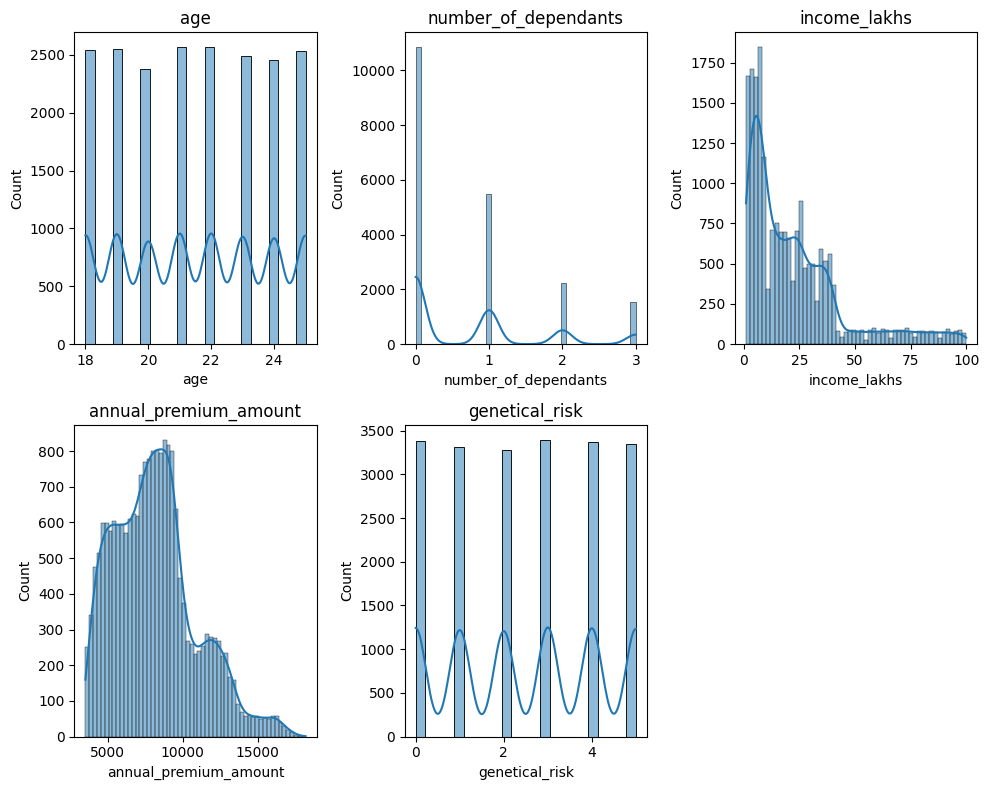

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,8))

for i, column in enumerate(numeric_columns):
    ax = axs[i//3, i%3]
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

if len(numeric_columns) % 3 != 0:
    for j in range(len(numeric_columns), 6):
        axs.flat[j].set_visible(False)
        
plt.tight_layout()
plt.show()

### Bivariate Analysis: Numeric Columns

In [26]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

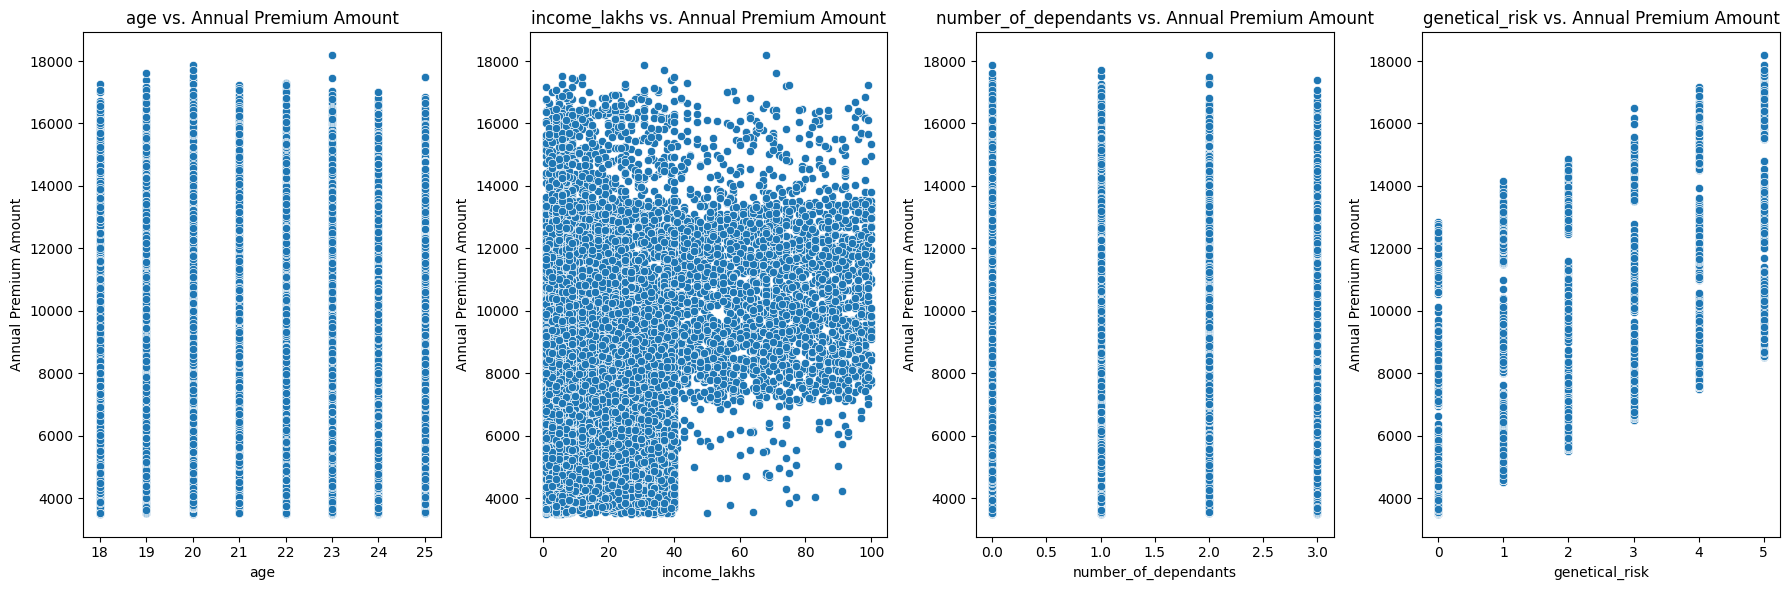

In [27]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants','genetical_risk']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18,6))

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f"{column} vs. Annual Premium Amount")
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

## Categorical Columns

In [28]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


#### Data Cleaning: smoking_status

In [29]:
df2['smoking_status'] = df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
})

df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Univariate Analysis: Categorical Columns

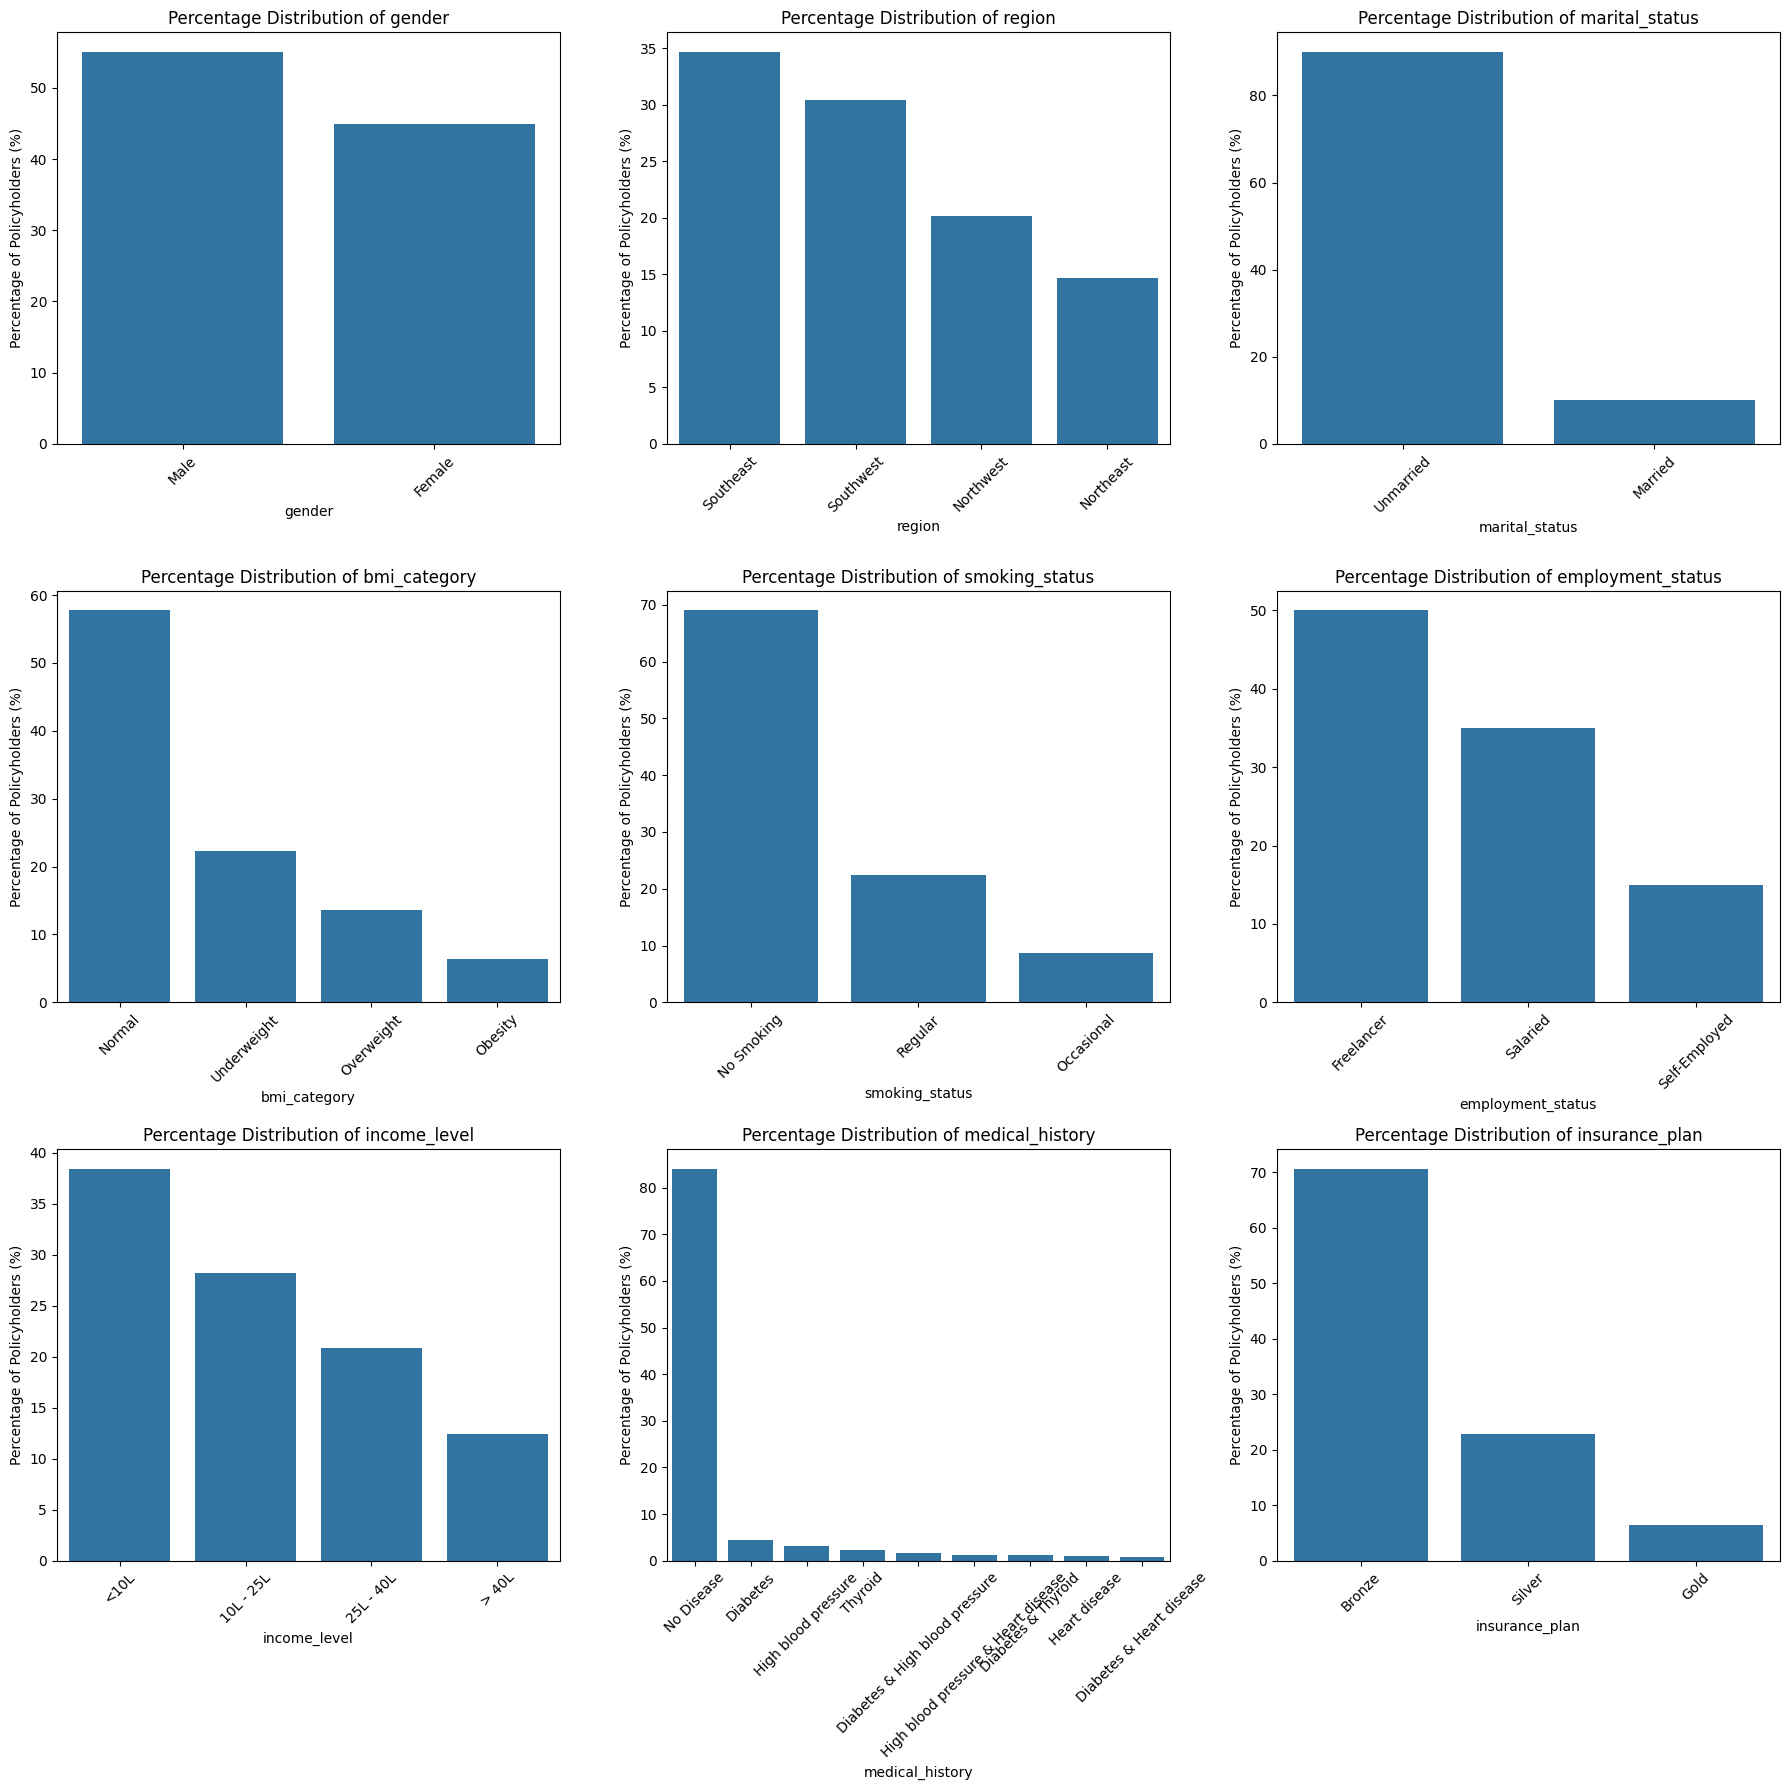

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(18,18))
axes = axes.flatten()

for ax, column in zip(axes, categorical_cols):
    category_counts = df2[column].value_counts(normalize=True) * 100

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

### Bivariate Analysis: Categorical Columns

In [31]:
# Cross-tabulation of income_level and insurnace_plan
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


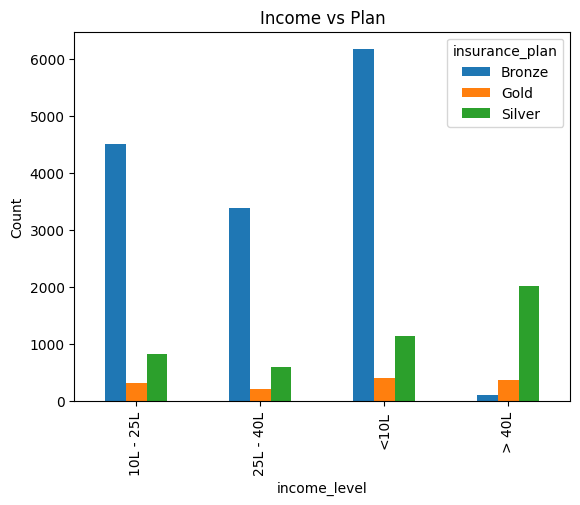

In [32]:
# Plotting the crosstab
crosstab.plot(kind='bar')
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.show()

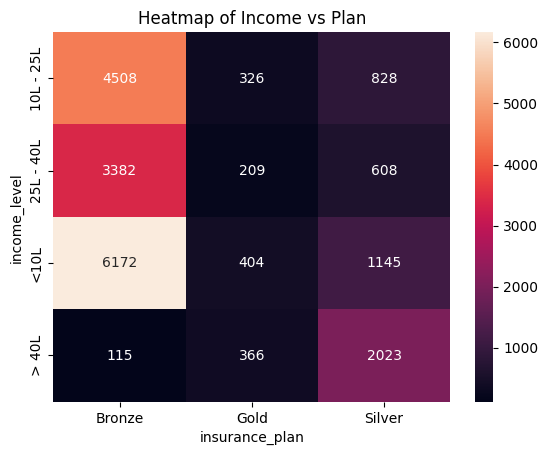

In [33]:
sns.heatmap(crosstab, annot=True,fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center>Feature Engineering</h2>

<h2 align="center" style="color:blue">Feature Engineering</h2>

In [34]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


### Calculate Risk Score

In [35]:
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [36]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "high blood pressure": 6,
    "heart disease": 8,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none,0,0.000000


### Encode Categorical Columns

In [37]:
df2['insurance_plan'].unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [38]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})

In [39]:
df2['income_level'].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [40]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [41]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [42]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   genetical_risk                   20086 non-null  int64  
 8   disease1                         20086 non-null  object 
 9   disease2                         20086 non-null  object 
 10  total_risk_score                 20086 non-null  int64  
 11  normalized_risk_score            20086 non-null  float64
 12  gender_Male            

<h2 align="center" style="color:blue">Feature Selection</h2>

In [43]:
df4 = df3.drop(columns=['medical_history', 'disease1', 'disease2', 'total_risk_score'])
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


### Calculate VIF for Multicollinearity

In [44]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

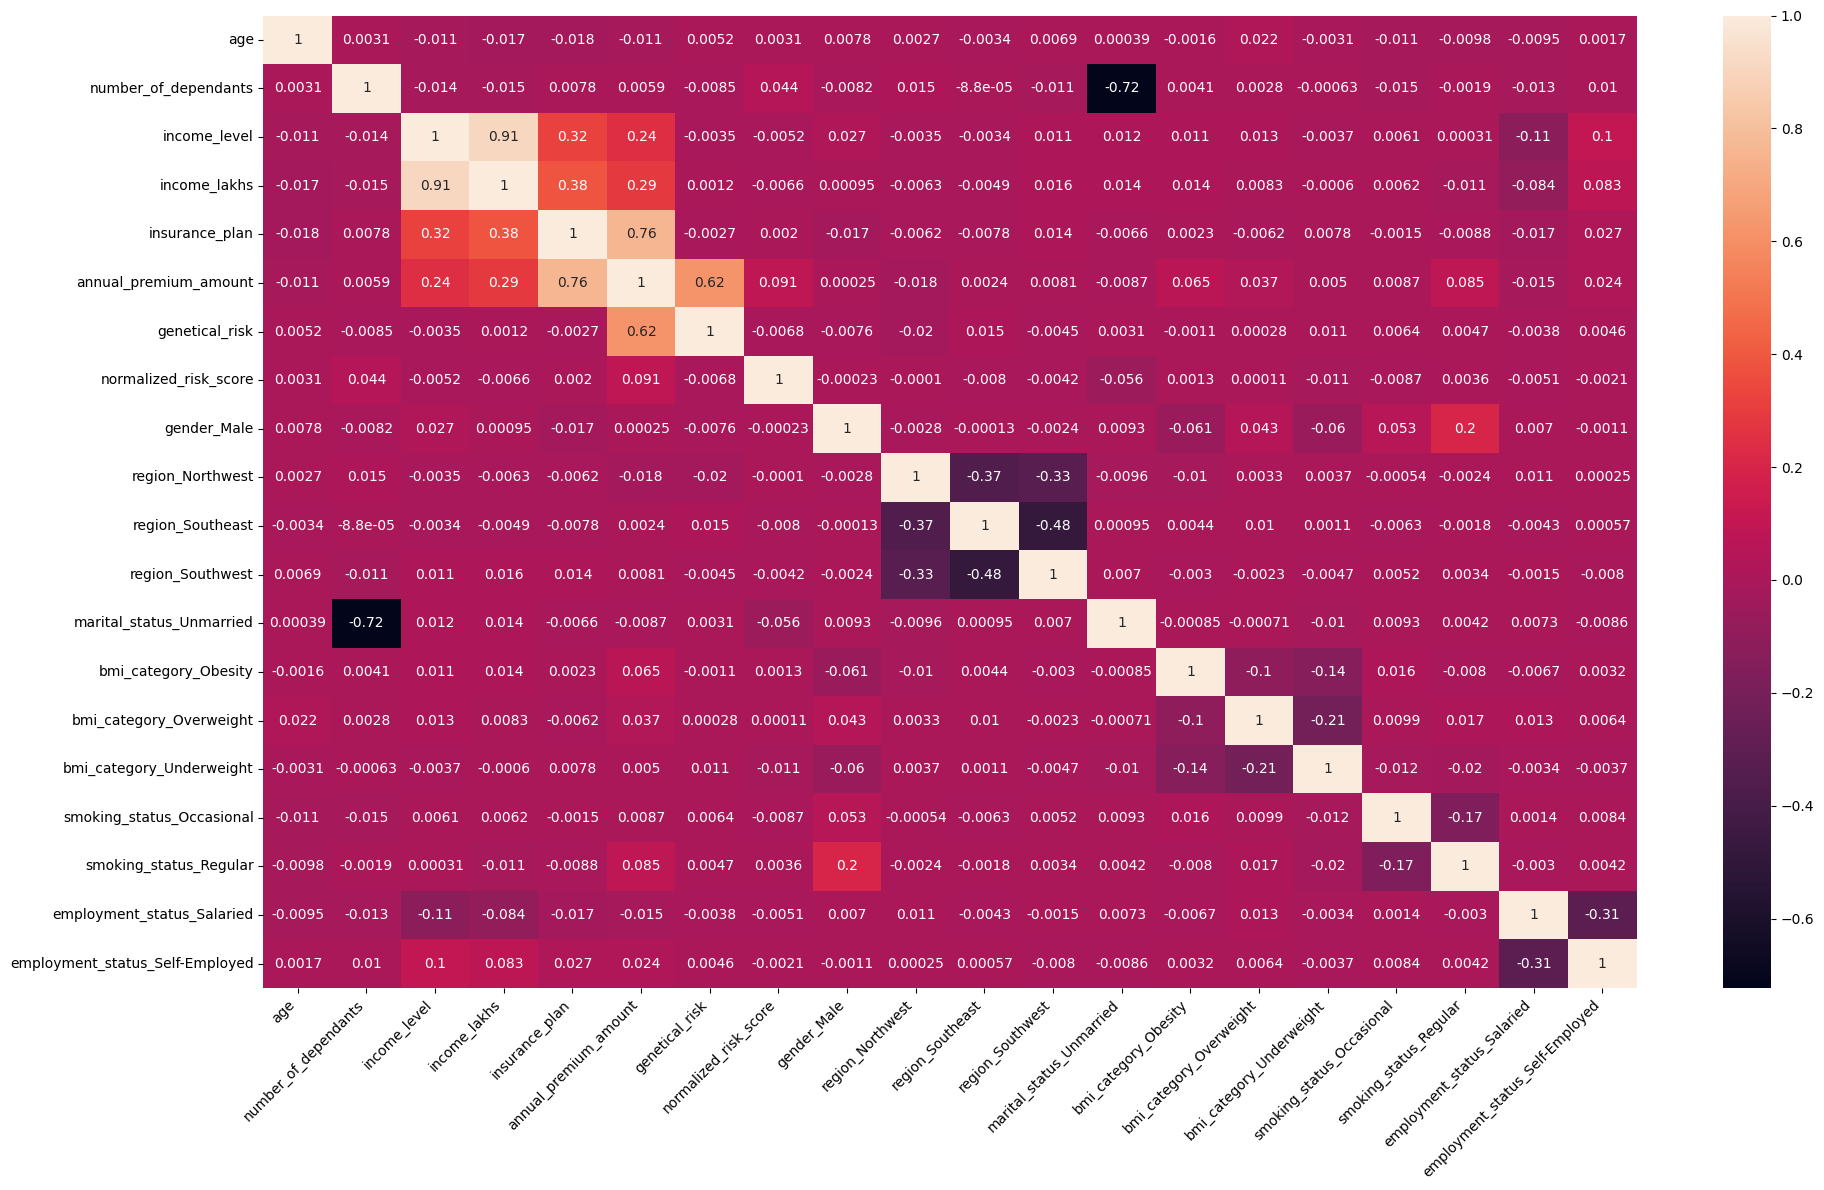

In [45]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
X = df4.drop(['annual_premium_amount'], axis='columns')
y = df4['annual_premium_amount']

cols_to_scale =['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan','genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [48]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [49]:
calculate_vif(X.drop('income_level', axis='columns'))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [50]:
# We will drop the income_level due to high VIF value
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


<h2 align="center" style="color:blue">Model Training</h2>

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 18)
x test:  (6026, 18)
y train:  (14060,)
y test:  (6026,)


### Linear Regression Model

In [52]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.9884990017445308, 0.9882609305654483)

In [53]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression ==> MSE:",mse_lr, "RMSE:",rmse_lr)

Linear Regression ==> MSE: 89439.73145260876 RMSE: 299.06476130197746


In [54]:
feature_importance = model_lr.coef_
feature_importance

array([-1.05801891e-01,  2.01069306e+01, -1.18192939e+01,  6.99564576e+03,
        4.98367534e+03,  1.13118985e+03,  6.08209851e+00,  1.91642829e+00,
        2.07974087e+00,  8.29849020e+00,  1.42155309e+01,  8.01977884e+02,
        4.04437286e+02,  1.13743592e+02,  2.07656492e+02,  6.07368444e+02,
        7.08985789e+00,  9.30425482e+00])

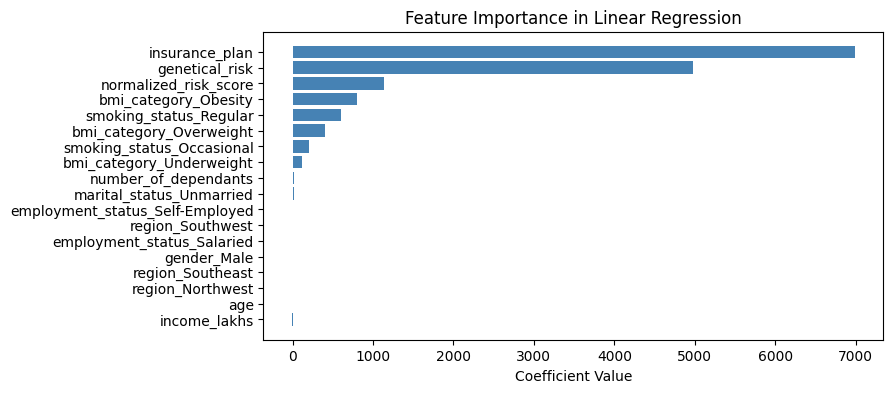

In [55]:
# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [56]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.988498397209062, 0.9882566783127196)

In [57]:
y_pred = model_rg.predict(X_test)

mse_rg = mean_squared_error(y_test, y_pred)
rmse_rg = np.sqrt(mse_lr)

print("Ridge Regression ==> MSE:",mse_rg, "RMSE:",rmse_rg)

Ridge Regression ==> MSE: 89472.1292797316 RMSE: 299.06476130197746


### RandomForest Regression Model

In [58]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
train_score = model_rf.score(X_train, y_train)
test_score = model_rf.score(X_test, y_test)
train_score, test_score

(0.9980541568058077, 0.986014382334566)

In [59]:
y_pred = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest Regressor ==> MSE:", mse_rf, "RMSE:", rmse_rf)

Random Forest Regressor ==> MSE: 106556.13676784192 RMSE: 326.42937485441155


In [60]:
model_rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None], 
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(model_rf, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

D:\Machine Learning Projects\Healthcare Premium Prediction\healthcare-env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='r2')

In [61]:
print(random_search.best_score_)
print(random_search.best_params_)
print(random_search.best_estimator_)

0.9873368865216737
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)


In [62]:
best_model = random_search.best_estimator_

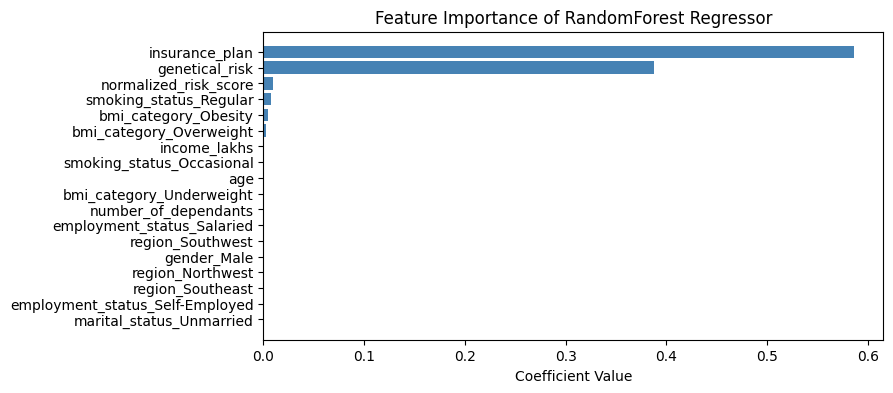

In [63]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance of RandomForest Regressor')
plt.show()

### XGBoost

In [64]:
model_xgb = XGBRegressor(n_estimators=100, max_depth=3)
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9893443584442139, 0.9885600805282593)

In [65]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)

print("Random Forest Regressor ==> MSE:", mse_xgb, "RMSE:", rmse_xgb)

Random Forest Regressor ==> MSE: 87160.68134446089 RMSE: 295.22987881388445


In [66]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50,100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50, 100]},
                   random_state=42, scoring='r2')

In [67]:
print(random_search.best_score_)
print(random_search.best_params_)
print(random_search.best_estimator_)

0.9886741638183594
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [68]:
best_model = random_search.best_estimator_

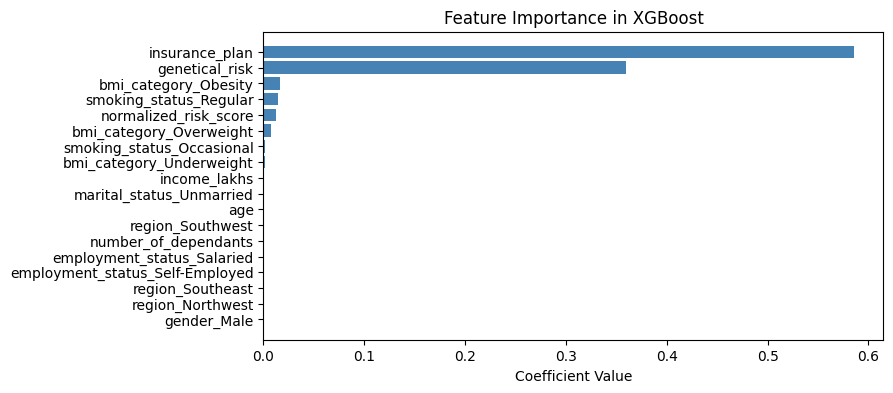

In [69]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

<h2 align="center" style="color:blue">Error Analysis</h2>

In [70]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

residuals_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
residuals_df.head()

,actual,predicted,diff,diff_pct
10489,5452,5420.592285,-31.407715,-0.576077
7989,9658,9134.927734,-523.072266,-5.415948
3113,6031,5791.844238,-239.155762,-3.965441
10605,12386,12253.444336,-132.555664,-1.070206
4204,4245,4703.137695,458.137695,10.792407


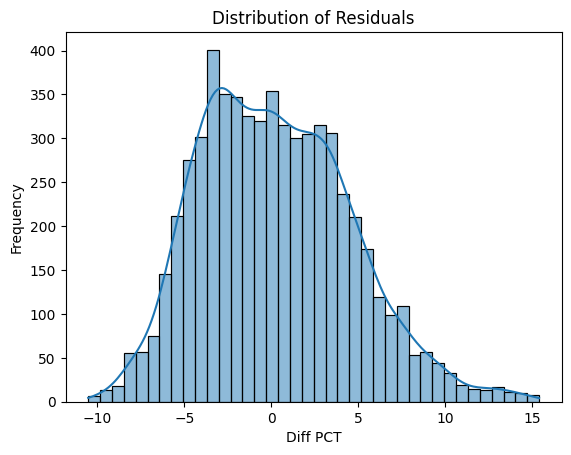

In [71]:
sns.histplot(residuals_df['diff_pct'], kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Diff PCT")
plt.ylabel('Frequency')
plt.show()

In [72]:
extreme_error_threhold = 10
extreme_results_df = residuals_df[np.abs(residuals_df['diff_pct']) > extreme_error_threhold]
extreme_results_df

,actual,predicted,diff,diff_pct
4204,4245,4703.137695,458.137695,10.792407
8862,4206,4629.177246,423.177246,10.061275
13142,4215,4727.731934,512.731934,12.164459
7802,4096,4558.332520,462.332520,11.287415
9881,3952,4429.636719,477.636719,12.085949
...,...,...,...,...
6345,3759,4216.833984,457.833984,12.179675
5925,4072,4494.242188,422.242188,10.369405
11264,3564,4039.716797,475.716797,13.347834
11302,3697,4124.887207,427.887207,11.573903


In [73]:
extreme_results_df.shape

(128, 4)

In [74]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

2.124128775307003

We have only 2% extreme errors.

In [75]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
4204,0.000000,0.000000,0.222222,0.0,0.0,0.000000,0,0,1,0,1,0,0,1,0,1,0,0
8862,0.714286,0.333333,0.010101,0.0,0.0,0.000000,1,0,0,0,1,0,0,0,0,1,1,0
13142,0.571429,0.666667,0.070707,0.0,0.0,0.428571,0,0,0,1,0,0,0,0,1,0,1,0
7802,0.857143,1.000000,0.020202,0.0,0.0,0.357143,1,0,1,0,0,0,0,1,0,0,0,0
9881,0.714286,0.000000,0.040404,0.0,0.0,0.000000,1,0,0,0,1,0,1,0,0,0,1,0


<h2 align="center" style="color:blue">Export the Model</h2>

In [78]:
columns = X_test.columns
columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [82]:
from joblib import dump

dump(best_model, "app/artifacts/model_young.joblib")

scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "app/artifacts/scaler_young.joblib")

columns = columns
dump(columns, "app/artifacts/columns.joblib")

['app/artifacts/columns.joblib']